# Building a Recommender System from Scratch

### Step 1: Import Dependencies

We are using [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) to represent our data. We will visualize our data with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

Let's download a small version of the MovieLens dataset. See here for zip file url, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our repository:

- ratings.csv
- movies.csv

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [3]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [4]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Step 3: Exploratory Data Analysis

In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


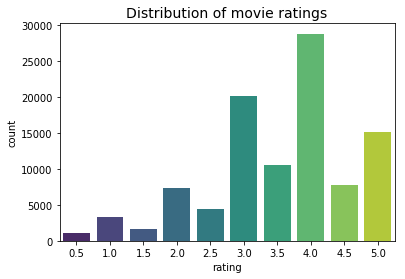

In [6]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

#### Best vs. Worst Movie

Which movie has the lowest and highest average rating?

In [61]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]


,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


`Santa with Muscles` has the lowest average rating.

In [72]:
highest_rated = mean_ratings['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie, but it only has one rating. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [64]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [65]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [73]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
0,318,311,4.487138,4.446203,"Shawshank Redemption, The (1994)"
1,858,200,4.487500,4.425014,"Godfather, The (1972)"
2,50,201,4.370647,4.314534,"Usual Suspects, The (1995)"
3,1221,135,4.385185,4.302614,"Godfather: Part II, The (1974)"
4,527,244,4.303279,4.259541,Schindler's List (1993)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [71]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2869,3593,19,1.210526,1.975099,Battlefield Earth (2000)
1242,1556,23,1.652174,2.183723,Speed 2: Cruise Control (1997)
2161,2701,47,2.031915,2.271446,Wild Wild West (1999)
489,546,17,1.735294,2.347912,Super Mario Bros. (1993)
1243,1562,47,2.148936,2.366224,Batman & Robin (1997)


With Bayesian average, it looks like `Battlefield Earth`, `Speed 2: Cruise Control` and `Wild Wild West` are the worst rated movies. `Santa with Muscles` isn't so bad after all.

### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="imgs/user-movie-matrix.png" width=60%/>

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [81]:
from utils import create_X

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

#### Evaluating sparsity

In [88]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.64%


`csr_matrix.nnz` gets the count of stored values in our sparse matrix. The rest of our cells are empty cells.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating.

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

### Part 2: Top N recommender